In [1]:
#Pakete importieren
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer
import time

In [2]:
#Dataframe erstellen in dem Ergebnisse gespeichert werden
#Spaltennamen definieren
columns_df = ["Modell", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
#Leeren Dataframe erstellen
ergebnisse = pd.DataFrame(columns=columns_df)

In [3]:
#Datensatz mit pandas einlesen
Data = pd.read_csv('/home/RDC/petukhia.hub/H:/petukhia.hub/Masterarbeit_Dilara/LC_Data_Clean.csv',low_memory = False)
                  
# Aufteilen der Daten in Features (X) und Zielvariable (y)
X = Data.drop('loan_status', axis=1)
y = Data['loan_status']

#Trainings und Test Datensatz erstellen
#10% vom Datensatz werden Testdaten
#random_state setzen um Ergebnis reproduzierbar zu machen
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 99) 

In [4]:
#Verteilung prüfen
verteilung = Data['loan_status'].value_counts() #unique values in der Spalte loan_status zählen
nd = verteilung[0] #ergebnis in not default und default aufteilen
de = verteilung[1]
gesamt= len(Data) #gesamt anzahl an Beobachtungen zählen

#Prozentanteil berechnen und ausgeben
print('Not Default: ', (nd/gesamt)*100, '%')
print('Default: ', (de/gesamt)*100, '%')

Not Default:  80.48955723923835 %
Default:  19.510442760761652 %


In [5]:
#Daten Scaling da die Spalten unterschiedliche Skalen haben
# Scaler für numerische Variablen initialisieren
scaler = StandardScaler()

###nummerische Trainingsdaten scalen###

#Numerische Variablen auswählen
#nummerische Spaltennamen werden zu einer Liste hinzugefügt
num_cols = ['loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'acc_now_delinq', 'tot_coll_amt', 
            'acc_open_past_24mths', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 
            'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
            'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 
            'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 
            'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 
            'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 
            'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'fico_average']
numerical_data_train = X_train[num_cols] #kategorische Spalten aus Datensatz entfernen
# Kategorische Variablen auswählen
categorical_data_train = X_train.drop(columns = num_cols) #Kategorische Spalten aus dem Trainingsdatensatz auswählen
# Index des ursprünglichen DataFrame speichern
index_train = numerical_data_train.index
# Scaler auf numerische Trainingsdaten anwenden
scaled_data_train = scaler.fit_transform(numerical_data_train)
# Skalierte numerische Daten in DataFrame zurückkonvertieren
X_train_scaled = pd.DataFrame(scaled_data_train, columns=num_cols, index= index_train)
# Skalierte numerische Daten und kategorische Daten wieder zusammenführen
X_train_scaled = pd.concat([X_train_scaled, categorical_data_train], axis=1)


#nummerische Testdaten scalen 
#Numerische Variablen auswählen
numerical_data_test = X_test[num_cols]
# Kategorische Variablen auswählen
categorical_data_test = X_test.drop(columns = num_cols)
# Index des ursprünglichen DataFrame speichern
index_test = numerical_data_test.index
# Scaler auf numerische Daten anwenden
scaled_data_test = scaler.transform(numerical_data_test) #nicht fit verwenden da auf Trainingsdaten gefittet wurde
# Skalierte numerische Daten in DataFrame zurückkonvertieren
X_test_scaled = pd.DataFrame(scaled_data_test, columns=num_cols, index= index_test)
# Skalierte numerische Daten und kategorische Daten wieder zusammenführen
X_test_scaled = pd.concat([X_test_scaled, categorical_data_test], axis=1)

In [6]:
#Modell implementieren und trainieren mit unskallierten Daten
model_unscaled = LogisticRegression(random_state=0,max_iter=1000) #Modellparameter definieren
log_reg_unscaled = model_unscaled.fit(X_train, y_train) #definiertes Modell mit Daten trainieren
#Genauigkeit ohne Scaling
# Genauigkeit auf den Trainingsdaten berechnen
accuracy_us = model_unscaled.score(X_train, y_train)
print(f"Genauigkeit ohne Scaling auf den Trainingsdaten: {accuracy_us}")
# Genauigkeit auf den Testdaten berechnen
accuracy2_us = model_unscaled.score(X_test, y_test)
print(f"Genauigkeit ohne Scaling auf den Testdaten: {accuracy2_us}")

Genauigkeit ohne Scaling auf den Trainingsdaten: 0.8051893719476794
Genauigkeit ohne Scaling auf den Testdaten: 0.8032503457814661


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [7]:
#Modell mit skalliertem Datensatz implementieren und trainieren
model = LogisticRegression(random_state=0,max_iter=1000) #Modellparameter festlegen
log_reg = model.fit(X_train_scaled, y_train) #Datensatz angeben mit dem Modell traineirt wird

#Genauigkeitsberechnung für Modell mit skalliertem Datensatz
print('Skallierter Datensatz')
# Genauigkeit auf den Trainingsdaten berechnen
accuracy = model.score(X_train_scaled, y_train)
print(f"Genauigkeit auf den Trainingsdaten: {accuracy}")
# Genauigkeit auf den Testdaten berechnen
accuracy2 = model.score(X_test_scaled, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy2}")

Skallierter Datensatz
Genauigkeit auf den Trainingsdaten: 0.8067646255250845
Genauigkeit auf den Testdaten: 0.8049792531120332


In [8]:
# Vorhersagen für die Testdaten berechnen
y_test_pred = model.predict(X_test_scaled)

#Testmetriken Precision, Recall, AUC und F1-Score berechnen

#Testdaten
modell = "Scaled + Unbalanced"
# Berechnung der Precision
precision_test = precision_score(y_test, y_test_pred)
print('Testdaten mit skalliertem Datensatz')
print('Precision: ', precision_test)
# Berechnung des Recall
recall_test = recall_score(y_test, y_test_pred)
print('Recall: ', recall_test)
# Berechnung des F1-Scores
f1_test = f1_score(y_test, y_test_pred)
print('F1: ', f1_test)
# Berechnung des ROC-AUC Score
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print('AUC: ',roc_auc_test)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[0] = [modell, accuracy2,precision_test,recall_test,f1_test,roc_auc_test]

Testdaten mit skalliertem Datensatz
Precision:  0.5466666666666666
Recall:  0.056
F1:  0.10159292035398229
AUC:  0.5223070372673779


In [9]:
#Hyperparameter anpassen

# Hyperparameter-Raster definieren
hyperparameters = {
   'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # Nur L2-Regularisierung
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga']
}

# Initialisieren Sie den Grid Search initialisieren
grid_search = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, scoring='accuracy')

#Grid-Search durchführen
grid_search.fit(X_train_scaled, y_train)

# Beste Hyperparameter-Kombination ausgeben
print("Beste Hyperparameter-Kombination:", grid_search.best_params_)

# Modell mit den besten Hyperparametern trainieren und evaluieren
model2 = LogisticRegression(**grid_search.best_params_,random_state=0, max_iter=10000)
#Modell trainieren
log_reg2 = model2.fit(X_train_scaled, y_train)

The line search algorithm did not converge
Line Search failed
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://

Beste Hyperparameter-Kombination: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [10]:
# Vorhersagen für die Testdaten berechnen
y_test_pred2 = model2.predict(X_test_scaled)

#Weitere Testmetriken für Testdaten aus Modell mit optimierten Hyperparametern
print('Modell mit angepassten Hyperparametern')
modell2 = "Scale + Hyperparamter"
#Berechnung Accuracy
accuracy_test2 = accuracy_score(y_test, y_test_pred2)
print('Accuracy Modell 2: ', accuracy_test2)
# Berechnung der Precision
precision_test2 = precision_score(y_test, y_test_pred2)
print('Precision Modell 2: ', precision_test2)
# Berechnung des Recall
recall_test2 = recall_score(y_test, y_test_pred2)
print('Recall Modell 2: ', recall_test2)
# Berechnung des F1-Scores
f1_test2 = f1_score(y_test, y_test_pred2)
print('F1 Modell 2: ', f1_test2)
# Berechnung des ROC-AUC Score
roc_auc_test2 = roc_auc_score(y_test, y_test_pred2)
print('AUC Modell 2: ',roc_auc_test2)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[1] = [modell2, accuracy_test2,precision_test2,recall_test2,f1_test2,roc_auc_test2]

Modell mit angepassten Hyperparametern
Accuracy Modell 2:  0.8052481942523436
Precision Modell 2:  0.5598290598290598
Recall Modell 2:  0.05112195121951219
F1 Modell 2:  0.09368853924548541
AUC Modell 2:  0.5206334532445455


In [11]:
# SMOTE anwenden
smote = SMOTE(random_state=42)#SMOTE algorithmus defineiren
X_train_resampled0, y_train_resampled = smote.fit_resample(X_train, y_train) #SMOTE auf Daten fitten

#Klassengewichtung vor SMOTE
unique0, counts0 = np.unique(y_train, return_counts=True) #einzigatige Werte werden gezählt, Anzahl und Werte werden in extra Array gespeichert
class_weights0 = dict(zip(unique0, counts0)) #Dictionary wird erstellt, Anzahl wird Wert zugeteilt
print("Klassengewichte vor SMOTE:", class_weights0)

# Überprüfen der Klassengewichte nach der Anwendung von SMOTE
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_weights = dict(zip(unique, counts))
print("Klassengewichte nach SMOTE:", class_weights)

Klassengewichte vor SMOTE: {0: 188592, 1: 45656}
Klassengewichte nach SMOTE: {0: 188592, 1: 188592}


In [12]:
#Ausgeglichener Datensatz wird erneut skalliert wie zuvor

# Scaler für numerische Variablen initialisieren
scaler = StandardScaler()

###nummerische Trainingsdaten scalen###

numerical_data_train0 = X_train_resampled0[num_cols] #kategorische Spalten aus Datensatz entfernen
# Kategorische Variablen auswählen
categorical_data_train0 = X_train_resampled0.drop(columns = num_cols) #Kategorische Spalten aus dem Trainingsdatensatz auswählen
# Index des ursprünglichen DataFrame speichern
index_train0 = numerical_data_train0.index
# Scaler auf numerische Trainingsdaten anwenden
scaled_data_train0 = scaler.fit_transform(numerical_data_train0)
# Skalierte numerische Daten in DataFrame zurückkonvertieren
X_train_resampled = pd.DataFrame(scaled_data_train0, columns=num_cols, index= index_train0)
# Skalierte numerische Daten und kategorische Daten wieder zusammenführen
X_train_resampled = pd.concat([X_train_resampled, categorical_data_train0], axis=1)


#nummerische Testdaten scalen 
#Numerische Variablen auswählen
numerical_data_test0 = X_test[num_cols]
# Kategorische Variablen auswählen
categorical_data_test0 = X_test.drop(columns = num_cols)
# Index des ursprünglichen DataFrame speichern
index_test0 = numerical_data_test0.index
# Scaler auf numerische Daten anwenden
scaled_data_test0 = scaler.transform(numerical_data_test0) #nicht fit verwenden da auf Trainingsdaten gefittet wurde
# Skalierte numerische Daten in DataFrame zurückkonvertieren
X_test_resampled = pd.DataFrame(scaled_data_test0, columns=num_cols, index= index_test0)
# Skalierte numerische Daten und kategorische Daten wieder zusammenführen
X_test_resampled = pd.concat([X_test_resampled, categorical_data_test0], axis=1)

In [13]:
#Model ohne angepasste Hyperparameter implementieren
model3 = LogisticRegression(random_state=0,max_iter=5000) #Modellparameter festlegen
#Max iter auf 5000 setzen da sonst nicht konvergiert
log_reg3 = model3.fit(X_train_resampled, y_train_resampled) #Modell mit ausgeglichenen und skallierten Daten trainieren

# Genauigkeit auf den Testdaten berechnen
accuracy_resampled = model3.score(X_test_resampled, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy_resampled}")
#Weitere Testmetriken
modell3 = "Scaled + SMOTE"
# Vorhersagen für die Testdaten berechnen
y_test_pred3 = model3.predict(X_test_resampled)
# Berechnung der Precision
precision_test3 = precision_score(y_test, y_test_pred3)
print('Precision Modell 3: ', precision_test3)
# Berechnung des Recall
recall_test3 = recall_score(y_test, y_test_pred3)
print('Recall Modell 3: ', recall_test3)
# Berechnung des F1-Scores
f1_test3 = f1_score(y_test, y_test_pred3)
print('F1 Modell 3: ', f1_test3)
#Berechnung AUC
#y_scores3 = model3.predict_proba(X_test_resampled)[:, 1]
auc3 = roc_auc_score(y_test, y_test_pred3)
print('AUC: ', auc3)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[2] = [modell3, accuracy_resampled,precision_test3,recall_test3,f1_test3,auc3]

Genauigkeit auf den Testdaten: 0.8049792531120332
Precision Modell 3:  0.5457943925233645
Recall Modell 3:  0.05697560975609756
F1 Modell 3:  0.10318021201413427
AUC:  0.5226752420880187


In [14]:
#Hyperparameter anpassen

# Hyperparameter-Raster definieren
hyperparameters = {
   'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # Nur L2-Regularisierung
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga']
}

# Initialisieren Sie den Grid Search initialisieren
grid_search2 = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, scoring='accuracy')

#Grid-Search durchführen
grid_search2.fit(X_train_resampled, y_train_resampled)

# Beste Hyperparameter-Kombination ausgeben
print("Beste Hyperparameter-Kombination:", grid_search2.best_params_)

# Modell mit den besten Hyperparametern trainieren und evaluieren
model4 = LogisticRegression(**grid_search2.best_params_,random_state=0, max_iter=5000)
#Modell trainieren
log_reg4 = model4.fit(X_train_resampled, y_train_resampled)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
The line search algorithm did not converge
Line Search failed
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not conve

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Beste Hyperparameter-Kombination: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


The line search algorithm did not converge
Line Search failed


In [15]:
# Vorhersagen für die Testdaten berechnen
y_test_pred4 = model4.predict(X_test_resampled)

#Testmetriken auf Testdaten berechnen für Ausgeglichenen und Skallierten Datensatz mit Hyperparameter-Anpassung
modell4 = "Scaled + SMOTE +\nHyperparameter"
#Berechnung Accuracy
accuracy_test4 = accuracy_score(y_test, y_test_pred4)
print('Accuracy Modell 4: ', accuracy_test4)
# Berechnung der Precision
precision_test4 = precision_score(y_test, y_test_pred4)
print('Precision Modell 4: ', precision_test4)
# Berechnung des Recall
recall_test4 = recall_score(y_test, y_test_pred4)
print('Recall Modell 4: ', recall_test4)
# Berechnung des F1-Scores
f1_test4 = f1_score(y_test, y_test_pred4)
print('F1 Modell 4: ', f1_test4)
#Berechnung AUC
#y_scores4 = model4.predict_proba(X_test_resampled)[:, 1]
auc4 = roc_auc_score(y_test, y_test_pred4)
print('AUC Modell 4: ', auc4)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[3] = [modell4, accuracy_test4, precision_test4, recall_test4, f1_test4, auc4]

Accuracy Modell 4:  0.7879975411095743
Precision Modell 4:  0.3572984749455338
Recall Modell 4:  0.096
F1 Modell 4:  0.1513380498308213
AUC Modell 4:  0.5268307898387792


In [16]:
#Modell erstellen
log_reg = LogisticRegression( penalty = 'l1', solver = 'liblinear', max_iter = 5000)
#
#Werte von C definieren
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

#Funktion zur Berechnung von BIC definieren
#def calculate_bic (y_true, y_pred, n, p):
    #residual = y_true - y_pred
  #  mse = np.mean(residual**2)
  #  bic = n * np.log(mse) + p * np.log(n)
   # return -bic #Minimierung des negativen BIC
def calculate_bic(y_true, y_pred):
    n = len(y_true)
    p = len(np.unique(y_true))
    residual = y_true - y_pred
    mse = np.mean(residual**2)
    bic = n * np.log(mse) + p * np.log(n)
    return -bic  # Minimierung des negativen BIC

#Grid Search mit BIC als Metric verwenden
bic_scorer = make_scorer(calculate_bic, greater_is_better=False)
 #greater_is_better=False)
grid_search = GridSearchCV(log_reg, param_grid, cv = 5, scoring = bic_scorer)
grid_search.fit (X_train_resampled, y_train_resampled)

#Besten Wert für C ausgeben
best_C = grid_search.best_params_['C']
print("Bestes C (basierend auf BIC):", best_C)

#Modellvorhersagen machen
model5 = grid_search.best_estimator_
y_tes_pred5 = model5.predict(X_test_resampled)

# Genauigkeit auf den Testdaten berechnen
accuracy_test5 = model5.score(X_test_resampled, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy_test5}")

# Die ausgewählten Feature-Indizes
selected_feature_indices = np.where(model5.coef_[0] != 0)[0]

# Die Namen der ausgewählten Features
selected_feature_names = X_train_resampled.columns[selected_feature_indices]

# Anzeigen der ausgewählten Feature-Namen
print("Ausgewählte Features:", selected_feature_names)

Bestes C (basierend auf BIC): 0.0001
Genauigkeit auf den Testdaten: 0.6843783617642539
Ausgewählte Features: Index(['loan_amnt', 'dti', 'acc_open_past_24mths', 'mo_sin_old_rev_tl_op',
       'mort_acc', 'mths_since_recent_inq', 'tot_hi_cred_lim', 'fico_average',
       'emp_length', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object')


In [17]:
# Startzeit messen
start_time = time.time()

#Modell trainieren
model5 = LogisticRegression(penalty='l1', C=grid_search.best_params_['C'] , solver='liblinear', max_iter=5000)

model5.fit(X_train_resampled, y_train_resampled)

# Endzeit messen
end_time = time.time()

#Name festlegen
modell5 = "Scaled + SMOTE +\nHyperparamter + Lasso"

# Vorhersagen für die Testdaten berechnen
y_test_pred5 = model5.predict(X_test_resampled)

# Genauigkeit auf den Testdaten berechnen
accuracy_test5 = model5.score(X_test_resampled, y_test)
print(f"Genauigkeit auf den Testdaten: {accuracy_test5}")
# Berechnung der Precision
precision_test5 = precision_score(y_test, y_test_pred5)
print('Precision Modell 5: ', precision_test5)
# Berechnung des Recall
recall_test5 = recall_score(y_test, y_test_pred5)
print('Recall Modell 5: ', recall_test5)
# Berechnung des F1-Scores
f1_test5 = f1_score(y_test, y_test_pred5)
print('F1 Modell 5: ', f1_test5)

# Die ausgewählten Feature-Indizes
selected_feature_indices = np.where(model5.coef_[0] != 0)[0]

# Die Namen der ausgewählten Features
selected_feature_names = X_train.columns[selected_feature_indices]

# Anzeigen der ausgewählten Feature-Namen
print("Ausgewählte Features:", selected_feature_names)

# Gesamtrechenzeit berechnen und ausgeben
elapsed_time = end_time - start_time
print(f"Gesamtrechenzeit: {elapsed_time} Sekunden")

Genauigkeit auf den Testdaten: 0.6843783617642539
Precision Modell 5:  0.2926731078904992
Recall Modell 5:  0.4255609756097561
F1 Modell 5:  0.3468235668283375
Ausgewählte Features: Index(['loan_amnt', 'emp_length', 'application_type',
       'chargeoff_within_12_mths', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl',
       'percent_bc_gt_75', 'total_bal_ex_mort', 'total_il_high_credit_limit',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object')
Gesamtrechenzeit: 1.951430082321167 Sekunden


Text(0.5, 1.0, 'Confusion Matrix für eine Logistic Regression')

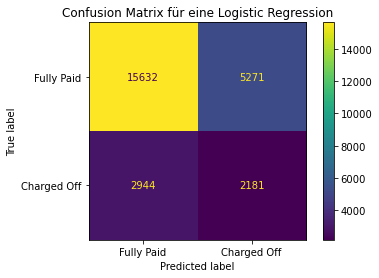

In [18]:
#Confusion Matrix berechnen
cm4 = confusion_matrix(y_test, y_test_pred5, labels=model5.classes_) #confusionmatrix für Testdaten berecnen
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, #Confusion Matrix plotten
                               display_labels=["Fully Paid", "Charged Off"]) #Labels beschriften

disp.plot()
plt.title('Confusion Matrix für eine Logistic Regression') #Überschrift festlegen
#plt.savefig('/home/RDC/petukhia.hub/H:/petukhia.hub/Masterarbeit_Dilara/CM_LR.jpg')

AUC:  0.6357605618518989


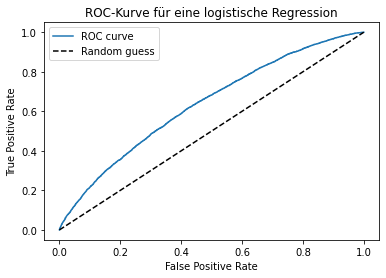

In [19]:
#ROC-Kurve erstellen 
#Modellhervorsagen berechnen
y_scores = model5.predict_proba(X_test_resampled)[:, 1]

#false positive und true positive rate berechnen
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

auc5 = roc_auc_score(y_test, y_scores)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[4] = [modell5, accuracy_test5, precision_test5, recall_test5, f1_test5, auc5]

print('AUC: ', auc5)

# ROC-Kurve plotten
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve für eine logistische Regression')
plt.legend()
#plt.savefig('/home/RDC/petukhia.hub/H:/petukhia.hub/Masterarbeit_Dilara/ROC_LR.jpg')
plt.show()

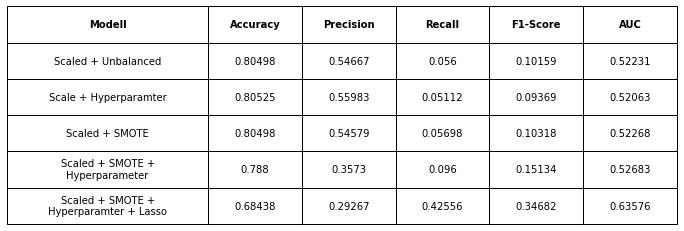

In [20]:
# Numerische Spalten auf 5 Nachkommastellen begrenzen
numerical_cols = ergebnisse.select_dtypes(include=['float64']).columns
ergebnisse[numerical_cols] = ergebnisse[numerical_cols].round(5)

# Tabelle erstellen
fig, ax = plt.subplots(figsize=(12, 4))  # Figur und Achsen erstellen
ax.axis('off')  # Achsen ausschalten

# Spaltenbreiten festlegen
col_widths = [0.3] + [0.14 for _ in range(ergebnisse.shape[1] - 1)]

# Tabellendiagramm erstellen
table = ax.table(cellText=ergebnisse.values, colLabels=ergebnisse.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1], colWidths=col_widths)

# Überschriften fett drucken
table.auto_set_font_size(False)
table.set_fontsize(10)  # Schriftgröße anpassen, falls gewünscht
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold')  # Überschrift fett drucken

#plt.savefig('/home/RDC/petukhia.hub/H:/petukhia.hub/Masterarbeit_Dilara/Ergebnisse_LR.jpg')
plt.show()

In [26]:
#Gewichtung der Features ausgeben lassen

# Die Koeffizienten (Gewichtungen) des Modells
coefficients = model5.coef_

# Die Namen der Features aus dem DataFrame
feature_names = X_train.columns

# Drucken Sie die Namen der Features und die zugehörigen Koeffizienten aus
for feature, coefficient in zip(feature_names, coefficients[0]):
    print(f"Feature: {feature}, Koeffizient: {coefficient}")

Feature: loan_amnt, Koeffizient: 0.12560588072236079
Feature: term, Koeffizient: 0.0
Feature: installment, Koeffizient: 0.0
Feature: emp_length, Koeffizient: 0.05134024341362956
Feature: annual_inc, Koeffizient: 0.0
Feature: dti, Koeffizient: 0.0
Feature: delinq_2yrs, Koeffizient: 0.0
Feature: inq_last_6mths, Koeffizient: 0.0
Feature: open_acc, Koeffizient: 0.0
Feature: pub_rec, Koeffizient: 0.0
Feature: revol_bal, Koeffizient: 0.0
Feature: revol_util, Koeffizient: 0.0
Feature: application_type, Koeffizient: 0.08888023734776286
Feature: acc_now_delinq, Koeffizient: 0.0
Feature: tot_coll_amt, Koeffizient: 0.0
Feature: acc_open_past_24mths, Koeffizient: 0.0
Feature: bc_open_to_buy, Koeffizient: 0.0
Feature: chargeoff_within_12_mths, Koeffizient: -0.011529271142398477
Feature: delinq_amnt, Koeffizient: 0.0
Feature: mo_sin_old_il_acct, Koeffizient: 0.0
Feature: mo_sin_old_rev_tl_op, Koeffizient: -0.10933181721097485
Feature: mo_sin_rcnt_rev_tl_op, Koeffizient: 0.0
Feature: mo_sin_rcnt_tl, 